# Artificial Reflector on Single-Axis-Tracked PV System
Modelling a PV test site in Golden, Colorado with 70% reflective artificial reflectors under the modules


# Load packages

In [ ]:
"""alewis 2022"""

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

#Import bifacial radiance code 
try:
    from bifacial_radiance import *
except ImportError:
    raise RuntimeError('bifacial_radiance is required!')

# Inputs for location, PV system, reflectors, etc

In [75]:
# Define locations within file system
test_folder = r'E:\NREL\Test_SAT_model' 
if not os.path.exists(test_folder):
    os.makedirs(test_folder)  

#Set up scan parameters
sensorsy = 20

#Set up scene parameters
lat = 39.7555 #Golden, CO
lon = -105.2211 #Golden, CO

#Set up system parameters
axis_azimuth = 90 # SAT modules with N/S axis
axis_tilt = 0
module_x = 1 #assume 1 meter width
module_y = 2 #assume 2 meter length
xgap = 0.05 #assume 5 cm gap between modules
ygap = 0.0 #1-UP system
hub_height = 1 #1.2 meters at shortest module edge
GCR = 0.35
albedo = 0.2 #Assume non-reflecting ground surface has albedo of ~0.2

num_panels = 1 #1-UP system
num_modules = 20 #20 modules per row
num_rows = 10 #10 rows of modules
pitch = 5.7 #pitch in m

TT_diameter = 0.130175 # 5 1/8 in
TT_gap = 0.055
torquetube = True #SAT case with torque tube
TT_material = 'Metal_Grey'
TT_type = 'round'
axisofrotationTorqueTube = False

limit_angle = 50
backtrack = True
cumulativesky = False

#Set up reflector parameters
reflector_length = 300 #reflector length in m
reflector_offset = 0 #reflector location, center with respect to torque tube
reflectance = 0.7 #% reflectance

#Set up module parameters
bf = 0.7
url = 'https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Modules.csv'
db = pd.read_csv(url, index_col=0) # Reading this might take 1 min or so, the database is big.
# print(db)
modfilter2 = db.index.str.startswith('LONGi') & db.index.str.endswith('LR6-60HIBD-305M')
CECMod = db[modfilter2]
print(len(CECMod), " modules selected. Name of 1st entry: ", CECMod.index[0])
Module_power = CECMod['STC'].values[0]
print(Module_power)
#Set up system parameters
DCACratio = 1.2

1  modules selected. Name of 1st entry:  LONGi Green Energy Technology Co. Ltd. LR6-60HIBD-305M
305.52


# Prepare variables for bifacial_radiance run

In [97]:
#Set up reflectors
reflector_offset_m = np.round(reflector_offset/100,2) #offset from lower edge of modules in N-S direction, convert cm to m
reflector_length_m = np.round(reflector_length/100,2) #length in meters in N-S direction (runs length of rows E-W), convert cm to m
reflector_width = (num_modules*(module_x+xgap))-xgap #reflectors end flush with edges of modules to N and S
reflector_tilt = 0 #keep flat on the ground
reflector_height = 0 #flush with the ground

rad_obj = RadianceObj('makemodules',path = test_folder) #Make Radiance object
epwfile = rad_obj.getEPW(lat, lon) #read weather file
demo_metfile = RadianceObj(simulation_string,str(test_folder))
metdata = demo_metfile.readWeatherFile(epwfile)
GHI = metdata.ghi
Temperature = metdata.temp_air
Wind_speed = metdata.wind_speed
Datetime = metdata.datetime
epw_len = len(GHI)


#Create new material for ground-reflecting material:
description = 'Custom reflecting ground sheet material'
ref_material_name = 'Ground_sheet'
#Start with (spectrally-invarying) albedo given
Rrefl = reflectance
Grefl = reflectance
Brefl = reflectance
rad_obj.addMaterial(material=ref_material_name, Rrefl=reflectance, Grefl=reflectance, Brefl=reflectance, comment=description)


 # Generate strings for this configuration
l_string = str(reflector_length).zfill(3)
o_string = str(reflector_offset).zfill(3)
#Generate module object and reflector object
reflector_modulename = 'reflector_' + l_string + 'cm'

#file name variables
simulation_name = 'SAT_Golden'
reflector_setup = 'refl_l'+l_string+'_o'+o_string

timestamps = np.array(list(range(1, epw_len)))
# timestamps = np.array(list(range(0, 100)))

path = E:\NREL\Test_SAT_model
Getting weather file: USA_CO_Golden-NREL.724666_TMY3.epw
 ... OK!
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
ADD MATERIAL - TEST
Material exists, overwriting...

Added material Ground_sheet to file ground.rad


# Run bifacial_radiance comparison 
### This will take a while!

In [72]:
for ts in timestamps:
    print("timestamp:"+str(ts))
    ts_string = str(ts).zfill(4)
    ghi_ts = GHI[ts]    
    
    simulation_string = simulation_name+'_w'+reflector_setup+'_ts'+ts_string
    demo = RadianceObj(simulation_string,str(test_folder))
    metdata = demo.readWeatherFile(epwfile)
    demo.setGround(metdata.albedo[ts])

       
    if ghi_ts == 0:
        print("Skip timestamp "+ts_string+", GHI = 0")
    else:
        tilt = demo.getSingleTimestampTrackerAngle(metdata, ts, gcr=GCR, azimuth=180, axis_tilt=0, limit_angle=limit_angle, backtrack=backtrack)
        if np.isnan(tilt):
            print("Skip timestamp "+ts_string+", tilt = nan!")         
        else:
             #FULL TEST W/REFLECTOR
            demo.gendaylit(ts)
            PV_module = demo.makeModule(name='PV_module',x=module_x,y=module_y,numpanels = num_panels, xgap=xgap, ygap=ygap)
            sceneDict1 = {'tilt':tilt,'pitch': pitch,'hub_height':hub_height,'azimuth':axis_azimuth, 'nMods': num_modules, 'nRows': num_rows,'originy':0,'originx':0,'appendRadfile':True}  
            scene1 = demo.makeScene(module=PV_module, sceneDict=sceneDict1) #makeScene creates a .rad file with 20 modules per row, 7 rows.

            #generate and place reflectors
#             reflector_module = demo.makeModule(name=reflector_modulename,x=reflector_width,y=reflector_length_m,numpanels = 1, xgap=0, ygap=0,modulematerial=ref_material_name)
            sceneDict2 = {'tilt':0,'pitch': pitch,'clearance_height':0,'azimuth':axis_azimuth, 'nMods': 1, 'nRows': num_rows,'originy': 0,'originx':reflector_offset_m,'appendRadfile':True}             
#             sceneDict2 = {'tilt':0,'pitch': pitch,'clearance_height':0,'azimuth':axis_azimuth, 'nMods': 1, 'nRows': num_rows,'originy': 0,'originx':0,'appendRadfile':True} 
            scene2 = demo.makeScene(module=reflector_module, sceneDict=sceneDict2)

            octfile = demo.makeOct(demo.getfilelist()) 
            analysis = AnalysisObj(octfile, demo.basename)  # return an analysis object including the scan dimensions for back irradiance
            frontscan, backscan = analysis.moduleAnalysis(scene1, sensorsy=sensorsy)
            analysis.analysis(octfile, simulation_string, frontscan, backscan)  # compare the back vs front irradiance  

            
            
            
            #REFERENCE CASE NO REFLECTOR
            ref_simulation_string = simulation_name+'_Ref_ts'+ts_string
            ref_demo = RadianceObj(ref_simulation_string,str(test_folder))
            ref_metdata = ref_demo.readWeatherFile(epwfile)
            ref_demo.setGround(ref_metdata.albedo[ts])
            ref_demo.gendaylit(ts)
            PV_module_ref = ref_demo.makeModule(name='PV_module_ref',x=module_x,y=module_y,numpanels = num_panels, xgap=xgap, ygap=ygap)
            sceneDict_ref = {'tilt':tilt,'pitch': pitch,'hub_height':hub_height,'azimuth':axis_azimuth, 'nMods': num_modules, 'nRows': num_rows,'originy':0,'originx':0,'appendRadfile':True}  
            scene_ref = ref_demo.makeScene(module=PV_module_ref, sceneDict=sceneDict_ref) #makeScene creates a .rad file with 20 modules per row, 7 rows.

            ref_octfile = ref_demo.makeOct(ref_demo.getfilelist()) 
            ref_analysis = AnalysisObj(ref_octfile, ref_demo.basename)  # return an analysis object including the scan dimensions for back irradiance
            ref_frontscan, ref_backscan = ref_analysis.moduleAnalysis(scene_ref, sensorsy=sensorsy)
            ref_analysis.analysis(ref_octfile, 'Reference_ts'+ts_string, ref_frontscan, ref_backscan)  # compare the back vs front irradiance  

path = E:\NREL\Test_SAT_model
Getting weather file: USA_CO_Golden-NREL.724666_TMY3.epw
 ... OK!
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
ADD MATERIAL - TEST
Material exists, overwriting...

Added material Ground_sheet to file ground.rad
timestamp:0
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg


Linescan in process: Reference_ts0004_Back
Saved: results\irr_Reference_ts0004.csv
timestamp:5
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0005.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0005_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0005_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0005.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the 

Linescan in process: Reference_ts0010_Back
Saved: results\irr_Reference_ts0010.csv
timestamp:11
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0011.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0011_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0011_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0011.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the

Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0016.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0016_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0016_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0016.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

C

Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0022.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0022_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0022_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0022.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

C

Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

Created SAT_Golden_Ref_ts0027.oct
Linescan in process: Reference_ts0027_Front
Linescan in process: Reference_ts0027_Back
Saved: results\irr_Reference_ts0027.csv
timestamp:28
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_modu

Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

Created SAT_Golden_Ref_ts0033.oct
Linescan in process: Reference_ts0033_Front
Linescan in process: Reference_ts0033_Back
Saved: results\irr_Reference_ts0033.csv
timestamp:34
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_modu

Linescan in process: Reference_ts0038_Back
Saved: results\irr_Reference_ts0038.csv
timestamp:39
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.
Skip timestamp 0039, tilt = nan!
timestamp:40
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 n

Linescan in process: Reference_ts0044_Back
Saved: results\irr_Reference_ts0044.csv
timestamp:45
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0045.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0045_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0045_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0045.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the

Linescan in process: Reference_ts0050_Back
Saved: results\irr_Reference_ts0050.csv
timestamp:51
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0051.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0051_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0051_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0051.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the

Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0056.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0056_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0056_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0056.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

C

Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0062.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0062_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0062_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0062.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

C

Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

Created SAT_Golden_Ref_ts0067.oct
Linescan in process: Reference_ts0067_Front
Linescan in process: Reference_ts0067_Back
Saved: results\irr_Reference_ts0067.csv
timestamp:68
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_modu

Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

Created SAT_Golden_Ref_ts0073.oct
Linescan in process: Reference_ts0073_Front
Linescan in process: Reference_ts0073_Back
Saved: results\irr_Reference_ts0073.csv
timestamp:74
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_modu

Linescan in process: Reference_ts0078_Back
Saved: results\irr_Reference_ts0078.csv
timestamp:79
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.
Skip timestamp 0079, tilt = nan!
timestamp:80
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 n

Linescan in process: Reference_ts0084_Back
Saved: results\irr_Reference_ts0084.csv
timestamp:85
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0085.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0085_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0085_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0085.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the

Linescan in process: Reference_ts0090_Back
Saved: results\irr_Reference_ts0090.csv
timestamp:91
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0091.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0091_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0091_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0091.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the

Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Created SAT_Golden_wrefl_l300_o000_ts0096.oct
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0096_Front
Linescan in process: SAT_Golden_wrefl_l300_o000_ts0096_Back
Saved: results\irr_SAT_Golden_wrefl_l300_o000_ts0096.csv
path = E:\NREL\Test_SAT_model
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loading albedo, 1 value(s), 0.330 avg
1 nonzero albedo values.

Module Name: PV_module_ref
Module PV_module_ref updated in module.json
Pre-existing .rad file objects\PV_module_ref.rad will be overwritten

C

# Summarize output data in pandas dataframe

In [114]:
resultsfolder = os.path.join(test_folder, 'results')

columns = ['Datetime','GHI',
           'avg_FrontIrrad','avg_RearIrrad','avg_TotalIrrad','MAD','Power_DC','Power_AC',\
           'ref_avg_FrontIrrad','ref_avg_RearIrrad','ref_avg_TotalIrrad','ref_MAD','ref_Power_DC','ref_Power_AC',\
           'front_irrGain','rear_irrGain','total_irrGain','total_energyGain_AC']
results_df = pd.DataFrame(columns=columns,index=timestamps)



avg_FrontIrrad = []
avg_RearIrrad = []
avg_TotalIrrad = []
MAD = []
Power_DC = []
Power_AC = []

ref_avg_FrontIrrad = []
ref_avg_RearIrrad = []
ref_avg_TotalIrrad = []
ref_MAD = []
ref_Power_DC = []
ref_Power_AC = []

front_irrGain = []
rear_irrGain = []
total_irrGain = []
total_energyGain_AC = []

for ts in timestamps:
    temp_air = Temperature[ts]
    wind_speed = Wind_speed[ts]
    ghi_ts = GHI[ts] 
    results_df.loc[ts,'GHI']=ghi_ts
    results_df.loc[ts,'Datetime']=Datetime[ts]
    tilt = demo.getSingleTimestampTrackerAngle(metdata, ts, gcr=GCR, azimuth=180, axis_tilt=0, limit_angle=limit_angle, backtrack=backtrack)
    if ghi_ts != 0 and not np.isnan(tilt):
        timestamp_list.append(ts)
        ts_string = str(ts).zfill(4) 
        simulation_string = simulation_name+'_w'+reflector_setup+'_ts'+ts_string
        sim_name = ('irr_'+simulation_string+'.csv')
        result_file = os.path.join(resultsfolder, sim_name)
        data = pd.read_csv(result_file)  
        
        FrontIrrad = data['Wm2Front'].to_numpy(dtype='float')
        RearIrrad = data['Wm2Back'].to_numpy(dtype='float')
        TotalIrrad = (bf*RearIrrad)+FrontIrrad
        
        results_df.loc[ts,'avg_FrontIrrad']=FrontIrrad.mean()
        results_df.loc[ts,'avg_RearIrrad']=RearIrrad.mean()
        results_df.loc[ts,'avg_TotalIrrad']=TotalIrrad.mean()
        MAD_ts = mismatch.mad_fn(TotalIrrad)
        results_df.loc[ts,'MAD']=MAD_ts
        
        MMloss_fit=0.054*(MAD_ts) + 0.068*np.square(MAD_ts)
        power_ts = performance.calculatePerformance(TotalIrrad.mean(),temp_air=temp_air,wind_speed=wind_speed,CECMod=CECMod)
        power_DC_ts = power_ts*(1-(MMloss_fit/100))
        results_df.loc[ts,'Power_DC']=power_DC_ts
        power_AC_ts = np.clip(power_DC_ts, 0, Module_power/DCACratio)
        results_df.loc[ts,'Power_AC']=power_AC_ts
        
        ref_name = ('irr_'+'Reference_ts'+ts_string+'.csv')
        reference_file = os.path.join(resultsfolder, ref_name)
        data_ref = pd.read_csv(reference_file) 
        
        ref_FrontIrrad = data_ref['Wm2Front'].to_numpy(dtype='float')
        ref_RearIrrad = data_ref['Wm2Back'].to_numpy(dtype='float')
        ref_TotalIrrad = (bf*ref_RearIrrad)+ref_FrontIrrad
        
        results_df.loc[ts,'ref_avg_FrontIrrad']=ref_FrontIrrad.mean()
        results_df.loc[ts,'ref_avg_RearIrrad']=ref_RearIrrad.mean()
        results_df.loc[ts,'ref_avg_TotalIrrad']=ref_TotalIrrad.mean()
        ref_MAD_ts = mismatch.mad_fn(ref_TotalIrrad)
        results_df.loc[ts,'ref_MAD']=ref_MAD_ts
        
        MMloss_fit=0.054*(ref_MAD_ts) + 0.068*np.square(ref_MAD_ts)
        ref_power_ts = performance.calculatePerformance(ref_TotalIrrad.mean(),temp_air=temp_air,wind_speed=wind_speed,CECMod=CECMod)
        ref_Power_DC_ts = ref_power_ts*(1-(MMloss_fit/100))
        results_df.loc[ts,'ref_Power_DC']=ref_Power_DC_ts
        ref_Power_AC_ts = np.clip(ref_Power_DC_ts, 0, Module_power/DCACratio)
        results_df.loc[ts,'ref_Power_AC']=ref_Power_AC_ts
        
        results_df.loc[ts,'front_irrGain'] = 100*((FrontIrrad.mean()-ref_FrontIrrad.mean())/ref_FrontIrrad.mean())
        results_df.loc[ts,'rear_irrGain'] = 100*((RearIrrad.mean()-ref_RearIrrad.mean())/ref_RearIrrad.mean())
        results_df.loc[ts,'total_irrGain'] = 100*((TotalIrrad.mean()-ref_TotalIrrad.mean())/ref_TotalIrrad.mean())
        results_df.loc[ts,'total_energyGain_AC'] = 100*((power_AC_ts-ref_Power_AC_ts)/ref_Power_AC_ts)

# Convert datetime column to datetime values 
results_df['Datetime'] = pd.to_datetime(results_df['Datetime'])
results_df['Datetime'] = results_df['Datetime'].dt.tz_localize(None)
print(results_df)        

                     Datetime  GHI avg_FrontIrrad avg_RearIrrad  \
0   2021-01-01 08:00:00-07:00    4      15.757358      3.574484   
1   2021-01-01 09:00:00-07:00  178      342.46516     28.761632   
2   2021-01-01 10:00:00-07:00   49      38.930903     16.809062   
3   2021-01-01 11:00:00-07:00  431      534.89295     78.579273   
4   2021-01-01 12:00:00-07:00  326     331.879305      77.79116   
..                        ...  ...            ...           ...   
95  2021-01-10 13:00:00-07:00  518      526.94499    100.896773   
96  2021-01-10 14:00:00-07:00  447      556.66151     66.156621   
97  2021-01-10 15:00:00-07:00  353      636.56998     45.588919   
98  2021-01-10 16:00:00-07:00  197     523.346915     11.573581   
99  2021-01-10 17:00:00-07:00   31            NaN           NaN   

   avg_TotalIrrad       MAD    Power_DC    Power_AC ref_avg_FrontIrrad  \
0       18.259497   8.12282    5.287741    5.287741          15.759863   
1      362.598302  0.784354  116.896636  116.89

# Calculate a few metrics for entire run

In [129]:
""" Summarize Results """
   
sum_FrontIrrad = np.sum(results_df['avg_FrontIrrad'])
sum_RearIrrad = np.sum(results_df['avg_RearIrrad'])
sum_TotalIrrad = np.sum(results_df['avg_TotalIrrad'])
sum_Power_DC = np.sum(results_df['Power_DC'])
sum_Power_AC = np.sum(results_df['Power_AC'])

sum_ref_FrontIrrad = np.sum(results_df['ref_avg_FrontIrrad'])
sum_ref_RearIrrad = np.sum(results_df['ref_avg_RearIrrad'])
sum_ref_TotalIrrad = np.sum(results_df['ref_avg_TotalIrrad'])
sum_ref_Power_DC = np.sum(results_df['ref_Power_DC'])
sum_ref_Power_AC = np.sum(results_df['ref_Power_AC'])

total_front_irrGain = 100*((sum_FrontIrrad-sum_ref_FrontIrrad)/sum_ref_FrontIrrad)
total_rear_irrGain=100*((sum_RearIrrad-sum_ref_RearIrrad)/sum_ref_RearIrrad)
total_total_irrGain=100*((sum_TotalIrrad-sum_ref_TotalIrrad)/sum_ref_TotalIrrad)
total_total_energyGain_AC=100*((sum_Power_AC-sum_ref_Power_AC)/sum_ref_Power_AC)

print("front irradiance gain:\t"+str(np.round(total_front_irrGain,2))+"%")
print("rear irradiance gain:\t"+str(np.round(total_rear_irrGain))+"%")
print("total irradiance gain:\t"+str(np.round(total_total_irrGain))+"%")
print("AC energy gain:\t\t"+str(np.round(total_total_energyGain_AC))+"%")

front irradiance gain:	0.28%
rear irradiance gain:	52.0%
total irradiance gain:	3.0%
AC energy gain:		3.0%


# Plot results - single day example

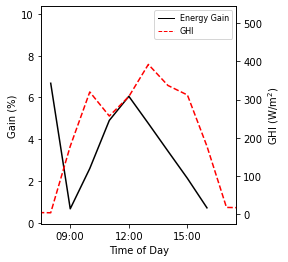

In [126]:
import matplotlib.dates as mdates
import datetime
from matplotlib.lines import Line2D

""" PLOT RESULTS """
fig_x = 3.5
fig_y = 4
titlesize = 10
labelsize = 8
lw = 1
markersize = lw*2

view_year = 2021
view_month = 1 #January
view_date = 3 #3rd

fig,ax = plt.subplots(figsize=(fig_x,fig_y)) 
ax2 = ax.twinx()
ax.plot(results_df['Datetime'],results_df['total_energyGain_AC'], ls="-", c="k")
ax2.plot(results_df['Datetime'],results_df['GHI'], ls="--", c="r")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
formatter = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim([datetime.datetime(view_year, view_month,view_date,7,30), datetime.datetime(view_year,view_month,view_date,17,30)])
ax.set_ylabel("Gain (%)",fontsize=titlesize)
ax2.set_ylabel("GHI (W/m$^2$)",fontsize=titlesize)
ax.set_xlabel("Time of Day",fontsize=titlesize)

custom_lines = [Line2D([0], [0], color='k', lw=lw,linestyle='-'),
                Line2D([0], [0], color='r', lw=lw,linestyle='--')]
custom_labels = ['Energy Gain','GHI']
ax.legend(custom_lines,custom_labels,fontsize=labelsize)